# (04) Dan notebook

**Motivation**: Load data, basic visualization, and linear fits: GLM + Ridge regression. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from model.dataset import setup_repeat_data, setup_supervised_data
from analysis.linear import *

# Load data

We will work with one of the experiments: ```expt='clu099'```

In [3]:
file = '/home/hadi/Documents/MTMST/data/MTLFP_tres25.h5'
file = h5py.File(file, 'r')

expt = 'clu099'
grp = file[expt]

### Create stimulus form 8 hyperflow params

In [4]:
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 5,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
print(f"stim shape: {stim.shape}")

stim shape: (72000, 19, 19, 2)

### Show a few frames from the stimulus

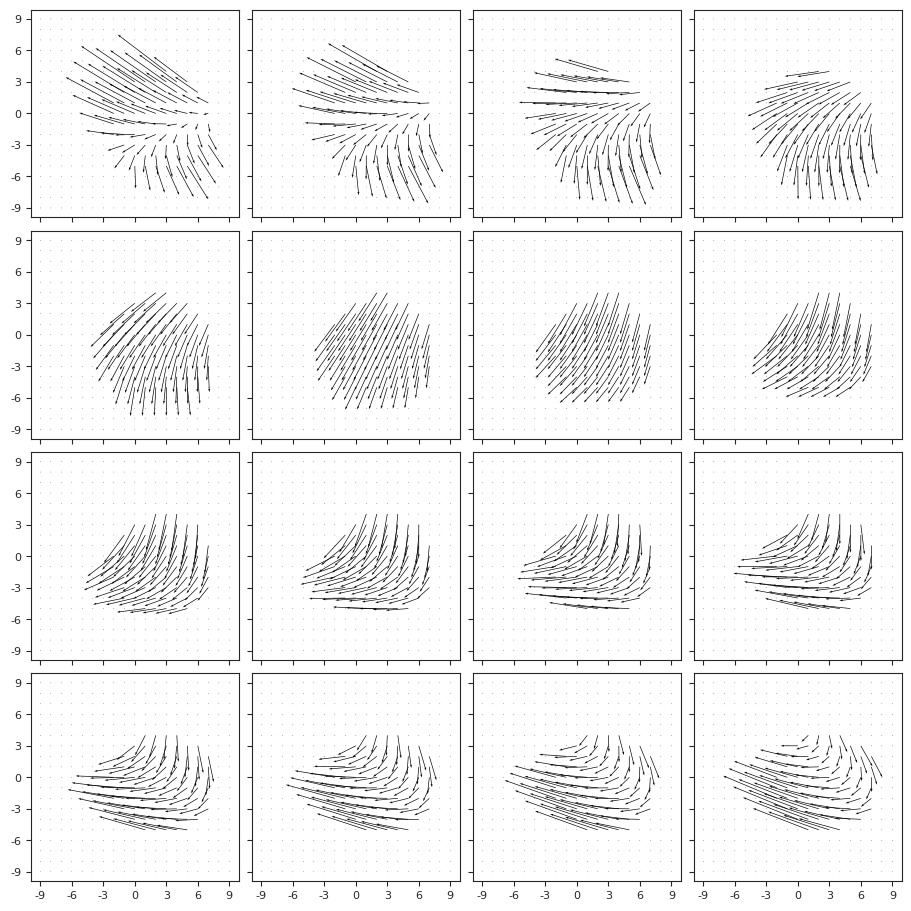

In [5]:
show_opticflow(stim);

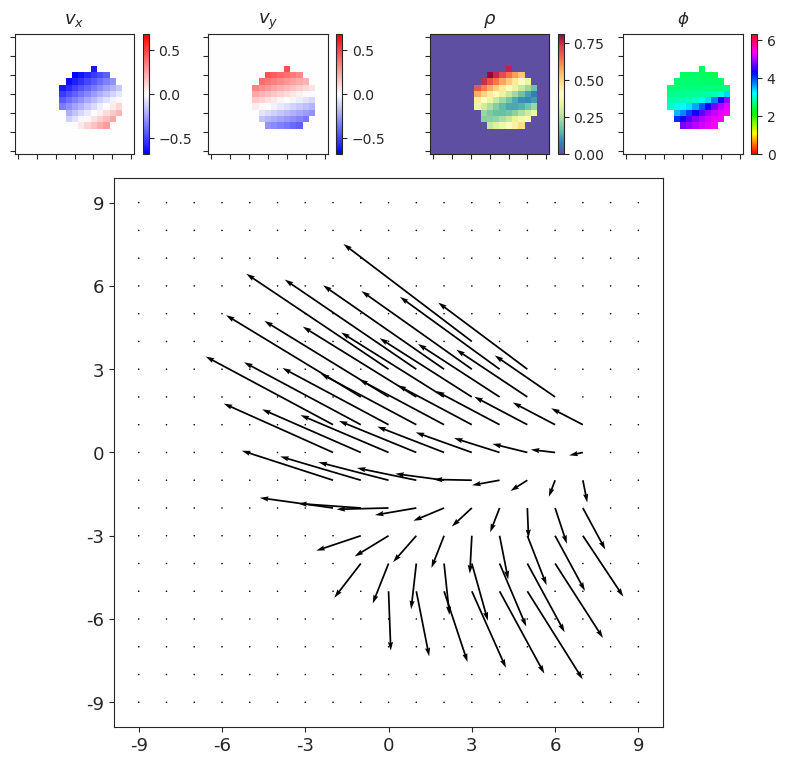

In [6]:
show_opticflow_full(stim[0]);

### Load spikes

In [7]:
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

print(f"good spks: {100 * len(good) / len(spks):0.1f} %")

good spks: 62.9 %

## Fit GLM

### Prepare (time embed)

In [11]:
lags = 16
src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags, hf_kws=hf_kws)

msg = f"stim: {src.shape}, spks: {tgt.shape}\n" 
if 'repeats' in grp:
    msg += f"stimR: {stim_r.shape}, spksR: {spks_r.shape}"
else:
    msg += f"stimR: {None}, spksR: {None}"
print(msg)

file.close()

stim: (45318, 16, 19, 19, 2), spks: (45318, 1)
stimR: (200, 16, 19, 19, 2), spksR: (1, 131, 200)

### Fit GLM

In [37]:
kws = {
    'category': 'PoissonRegressor',
    'alphas': [1, 10, 30, 50, 80, 100],
    'verbose': True,
    'n_folds': 5,
    'seed': 0,
}
channel = 0
kws = {
    'x': src,
    'y': tgt[:, channel],
    'x_tst': stim_r,
    'y_tst': np.nanmean(spks_r[channel], 0) if spks_r is not None else None,
    **kws,
}

In [38]:
%%time

glm = LinearModel(**kws).fit()

Category: 'PoissonRegressor', default params:
{'alpha': 1.0, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001, 'warm_start': False, 
'verbose': 0}

CPU times: user 47min 49s, sys: 25.9 s, total: 48min 15s
Wall time: 2min 18s


In [39]:
glm.r2_tst

{1: -433.22975165620824,
 10: 6.552521697385883,
 30: 22.565445567202524,
 50: 18.107718503476388,
 80: 13.309516067337512,
 100: 11.267663796511862}

In [40]:
glm.r_tst

{1: 0.41299133671289656,
 10: 0.47318407071842006,
 30: 0.4879439790529754,
 50: 0.4902542587736626,
 80: 0.49080379774605987,
 100: 0.49139796788723955}

In [41]:
glm.df

,nnll,r2,r
alpha,,,
1,0.241049,-434.287145,0.393816
10,0.122859,6.517361,0.372595
30,0.059787,22.547371,0.355866
50,0.039490,18.093788,0.350155
80,0.026099,13.296959,0.346394
100,0.021276,11.255343,0.345007


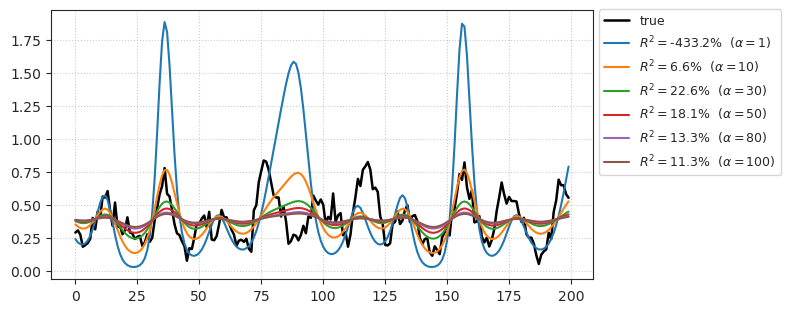

In [42]:
glm.show_pred();

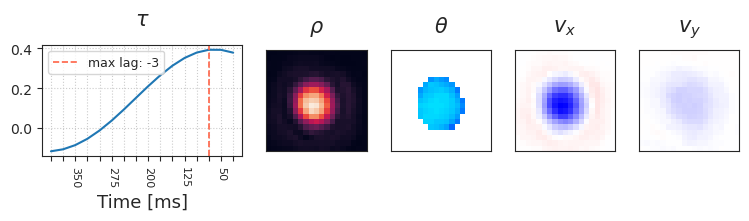

In [44]:
glm.kers[30].show();

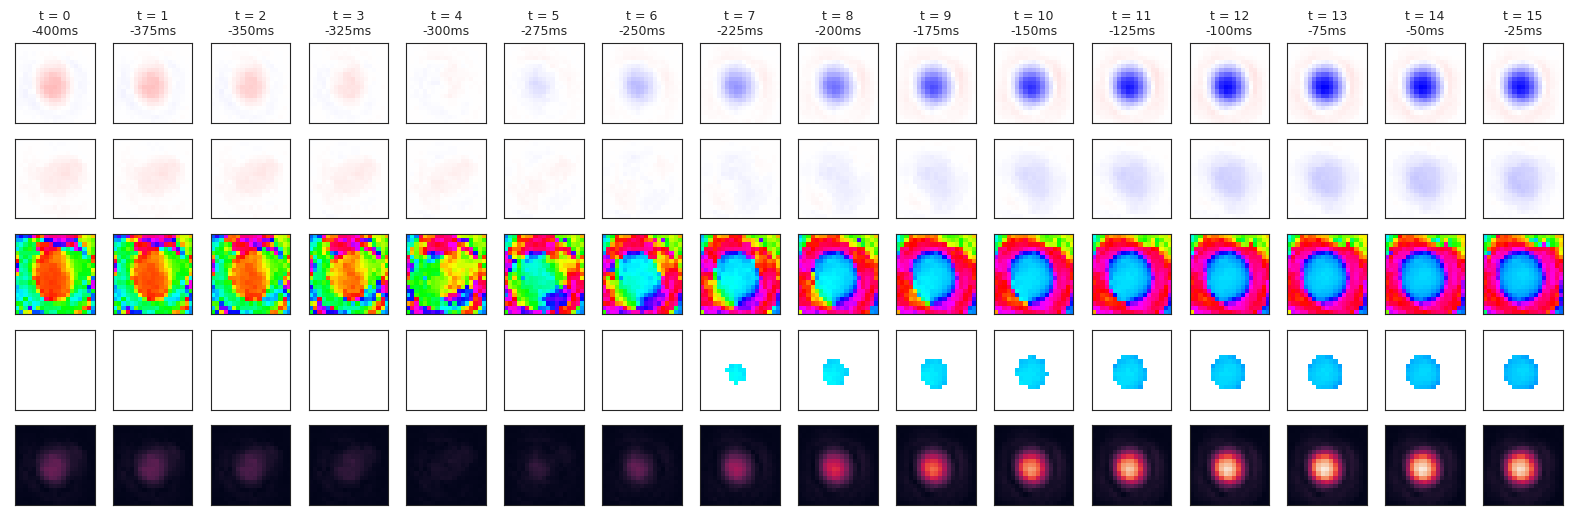

In [45]:
glm.kers[30].show_full();

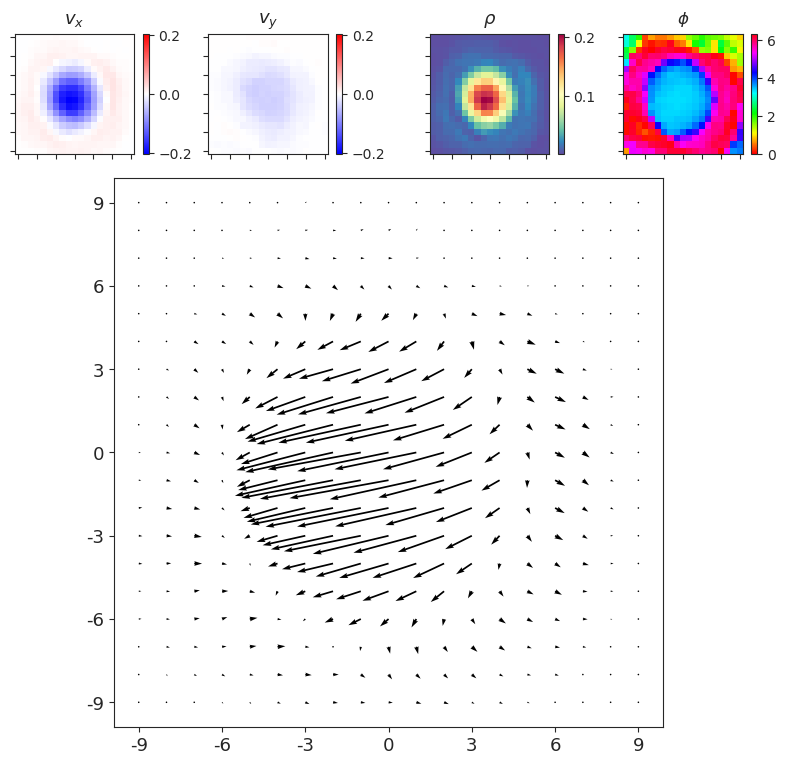

In [49]:
tker, sker = glm.kers[30].get_kers(0)
_ = show_opticflow_full(sker[0], scale=1.1)

## Ridge regression

In [66]:
%%time

kws['category'] = 'Ridge'
kws['alphas'] = [1e2, 1e4, 1e6, 1e8]
ridge = LinearModel(**kws).fit()

Category: 'Ridge', default params:
{'alpha': 1.0, 'fit_intercept': True, 'normalize': False, 'copy_X': True, 'max_iter': None, 
'tol': 0.001, 'solver': 'auto', 'random_state': 0}

CPU times: user 1h 23min 17s, sys: 13min 49s, total: 1h 37min 6s
Wall time: 5min 35s


In [67]:
ridge.r2_tst

{100.0: -492.84446713997136,
 10000.0: -535.4089166187075,
 1000000.0: 1.6995581632989976,
 100000000.0: 1.5833470558342722}

In [68]:
ridge.r_tst

{100.0: 0.5654645394138909,
 10000.0: 0.5353233783450251,
 1000000.0: 0.5054371219996902,
 100000000.0: 0.4920224602702661}

In [69]:
ridge.df

,nnll,r2,r
alpha,,,
100.0,0.077289,-516.842746,0.439223
10000.0,0.202103,-523.437300,0.425047
1000000.0,0.116203,12.193662,0.362195
100000000.0,0.001853,1.258313,0.339137


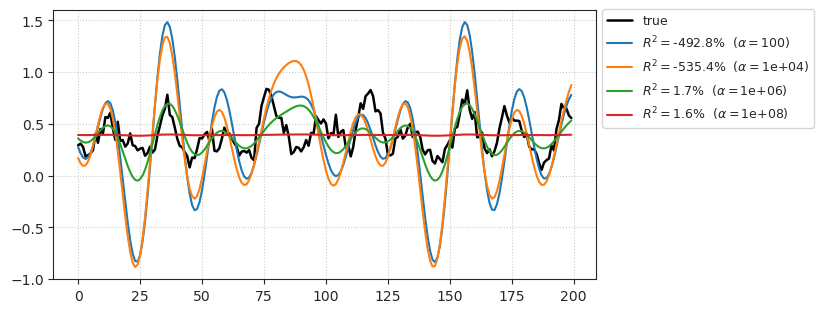

In [70]:
ridge.show_pred();

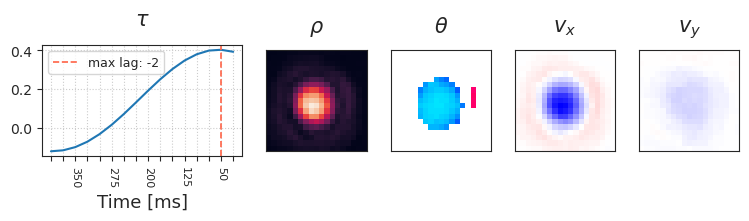

In [71]:
ridge.kers[1e6].show();

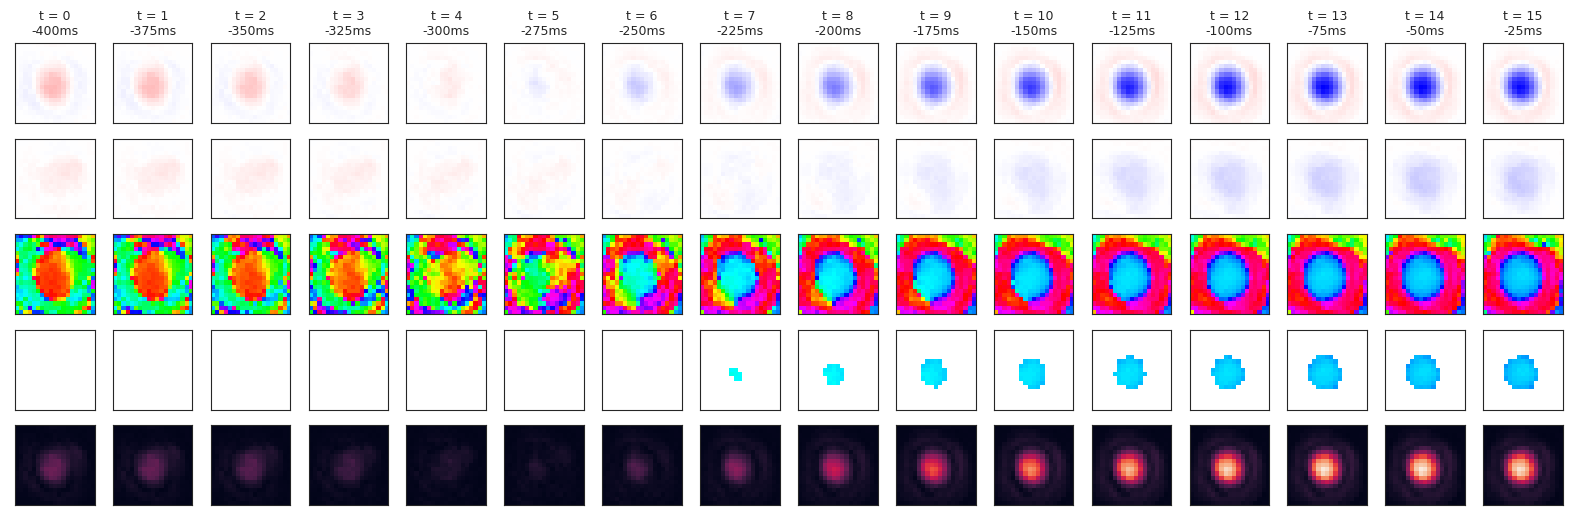

In [72]:
ridge.kers[1e6].show_full();

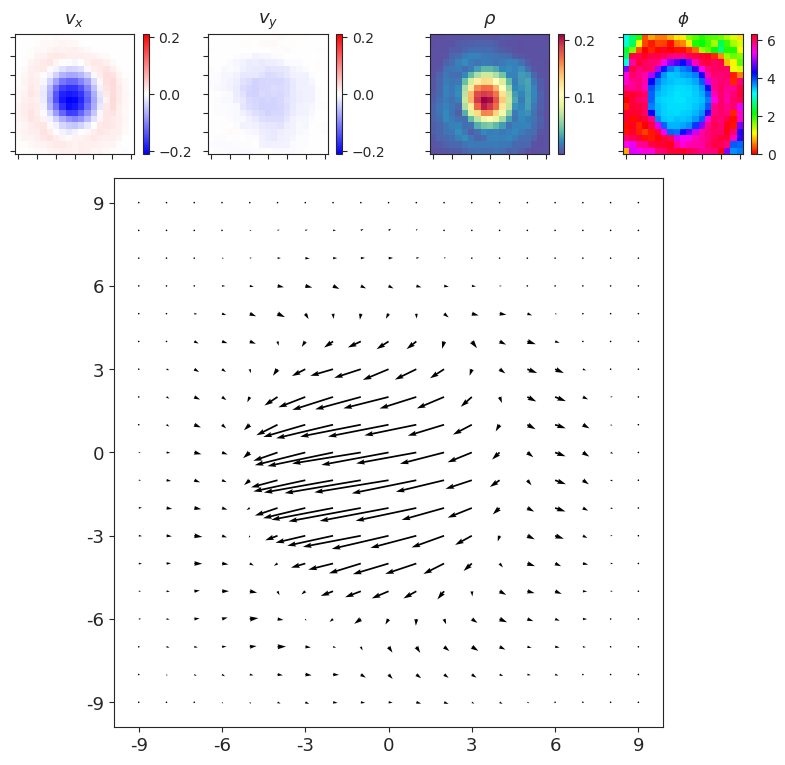

In [73]:
tker, sker = ridge.kers[1e6].get_kers(0)
_ = show_opticflow_full(sker[0], scale=1.5)